In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']
ORDERED_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT', 'SOMEWHAT OPPOSE', 'DEFINITELY OPPOSE']

APPROVE_TAGS = ['APPROVED', 'APPROVED IN PART OR WITH MODIFICATIONS']



## Data Preparation

In [2]:
dfa = dt.get_agenda_items()
dfm = dt.get_minutes(verbose=False)
dfl = dt.get_supplemental_docs(verbose=False)

In [3]:
# Keep only applications not withdrawn
idx = dfm['project_result']!='APPLICATION WITHDRAWN'
dfm = dfm.loc[idx].reset_index(drop=True)

In [4]:
# Keep only supporting or opposing letters
idx = dfl['support_or_oppose'].isin(SUPPORT_TAGS + OPPOSE_TAGS)
dfl = dfl.loc[idx].reset_index(drop=True)

In [5]:
# Count support and opposition for minutes items
for so in ['support', 'oppose']:
    for typ in ['', 'individual', 'official', 'other']:
        dfm[f'n_{typ}_{so}'] = 0
        
for idx, irow in dfm.iterrows():
    date = irow['date']
    item_no = irow['item_no']
    for jdx, jrow in dfl.loc[dfl['date']==date].iterrows():
        referenced_items = [s.strip() for s in jrow['referenced_items'].split(',')]
        is_so = {}
        is_so['support'] = jrow['support_or_oppose'] in SUPPORT_TAGS
        is_so['oppose'] = jrow['support_or_oppose'] in OPPOSE_TAGS
        is_type = {}
        is_type[''] = 1
        is_type['individual'] = 1*(jrow['author_type']=='INDIVIDUAL')
        is_type['official'] = 1*(jrow['author_type']=='PUBLIC OFFICIAL')
        is_type['other'] = 1 - is_type['individual'] - is_type['official']
        if item_no in referenced_items:
            for so in ['support', 'oppose']:
                for typ in ['', 'individual', 'official', 'other']:
                    dfm.loc[idx, f'n_{typ}_{so}'] += is_type[typ]*is_so[so]

In [6]:
# Deliberation order for minutes items
dfm['deliberation_order'] = dfm.groupby('date')[
    'minutes_start_line'
].rank(method='dense', ascending=True)

In [7]:
# Total number of agenda items for each meeting
tempdf = dfa.groupby('date').agg(num_agenda_items=('item_no','count')).reset_index()
dfm = dfm.merge(tempdf, on='date', how='left')

In [8]:
# consent calendar indicator
tempdf = dfa[['date', 'item_no', 'is_cc_part']]
dfm = dfm.merge(tempdf, on=['date', 'item_no'], how='left')
dfm['consent_calendar'] = 1*dfm['is_cc_part']

## Descriptive Data

In [9]:
# Results
dfm['project_result'].fillna('N/A').value_counts()

project_result
APPROVED                                  396
APPROVED IN PART OR WITH MODIFICATIONS    214
DELIBERATIONS CONTINUED TO FUTURE DATE    112
DENIED                                      7
Name: count, dtype: int64

In [10]:
# Support/oppose
dfl['support_or_oppose'].fillna('N/A').value_counts()

support_or_oppose
DEFINITELY OPPOSE     2134
DEFINITELY SUPPORT    1794
SOMEWHAT SUPPORT       305
SOMEWHAT OPPOSE        296
Name: count, dtype: int64

In [11]:
# Support/oppose by author type
dfl['support_or_oppose'] = pd.Categorical(
    dfl['support_or_oppose'], categories=ORDERED_TAGS, ordered=True
)
pd.crosstab(dfl['author_type'].fillna('N/A'), dfl['support_or_oppose'])

support_or_oppose,DEFINITELY SUPPORT,SOMEWHAT SUPPORT,SOMEWHAT OPPOSE,DEFINITELY OPPOSE
author_type,,,,
ADVOCACY GROUP,325,91,74,296
CONSULTANT,114,13,17,35
DEVELOPER,55,9,4,3
INDIVIDUAL,1052,156,165,1643
LAWYER,124,17,25,145
OTHER,15,1,2,5
PUBLIC OFFICIAL,109,18,9,7


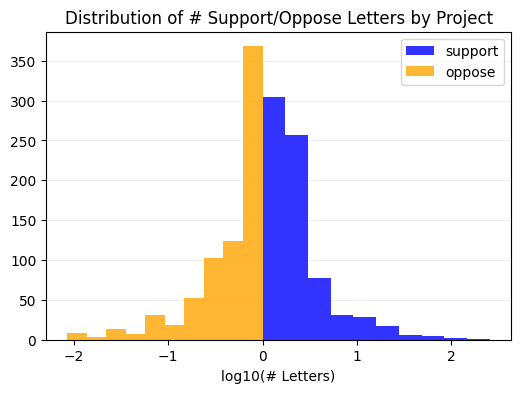

In [12]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(dfm['n__support']+1), alpha=0.8, color='blue', label='support')
plt.hist(-np.log10(dfm['n__oppose']+1), alpha=0.8, color='orange', label='oppose')
plt.xlabel('log10(# Letters)')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
plt.title("Distribution of # Support/Oppose Letters by Project")
plt.show()

In [23]:
for so in ['support', 'oppose']:
    for typ in ['', 'individual', 'official', 'other']:
        dfm[f'log2_{typ}_{so}'] = np.log(dfm[f'n_{typ}_{so}']+1)/np.log(2)

x1 = ['num_agenda_items']
x2 = x1 + ['consent_calendar', 'deliberation_order']
x3 = x2 + ['log2__support', 'log2__oppose']
x4 = x2 + [
    'log2_individual_support', 'log2_individual_oppose',
    'n_official_support', 'n_official_oppose',
    'n_other_support', 'n_other_oppose'
]
xshow = ['const'] + x3 + [
    'log2_individual_support', 'log2_individual_oppose',
    'n_official_support', 'n_official_oppose',
    'n_other_support', 'n_other_oppose'
]
y = dfm['project_result'].isin(APPROVE_TAGS)

X1 = sm.add_constant(dfm[x1])
X2 = sm.add_constant(dfm[x2])
X3 = sm.add_constant(dfm[x3])
X4 = sm.add_constant(dfm[x4])

mod1 = sm.Logit(y, X1).fit()
mod2 = sm.Logit(y, X2).fit()
mod3 = sm.Logit(y, X3).fit()
mod4 = sm.Logit(y, X4).fit()

sg = Stargazer([mod1, mod2, mod3, mod4])
sg.covariate_order(xshow)
sg.title(title="Logit Regression: Success=Approve/Approve with Minor Changes")
sg

Optimization terminated successfully.
         Current function value: 0.444508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404633
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405924
         Iterations 8


In [ ]:
dfm['is_cc_part'].astype('int')